In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import yaml

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

In [3]:
score_name = "flair_score"

In [4]:
filepaths = yaml.load(open("/home/guilherme/Desktop/dissertation/config/filepaths.yaml"))

bins = np.linspace(0, 1, num=20)

/tmp/ipykernel_11668/3149349683.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  filepaths = yaml.load(open("/home/guilherme/Desktop/dissertation/config/filepaths.yaml"))


#### Build CORAAL's data description

In [5]:
filenames = [file.split("/")[-1] for file in glob.glob(os.path.join(filepaths["04_twitter_scored"], "*"))]

data = []
for filename in filenames:
    description = {}
    
    description["filename"] = filename
    description["group"] = filename.split("_")[0]
    
    data.append(description)
    
df_data_desc = pd.DataFrame(data)

df_data_desc["group"] = (
    df_data_desc
    .group.apply(
        lambda group: "Black"
        if group=='aa'
        else "White"
    )
)

---

### Toxicity Score Cumulative Distribution Function (CDF)

Group: `Black` had 0 reading problems
Group: `White` had 0 reading problems


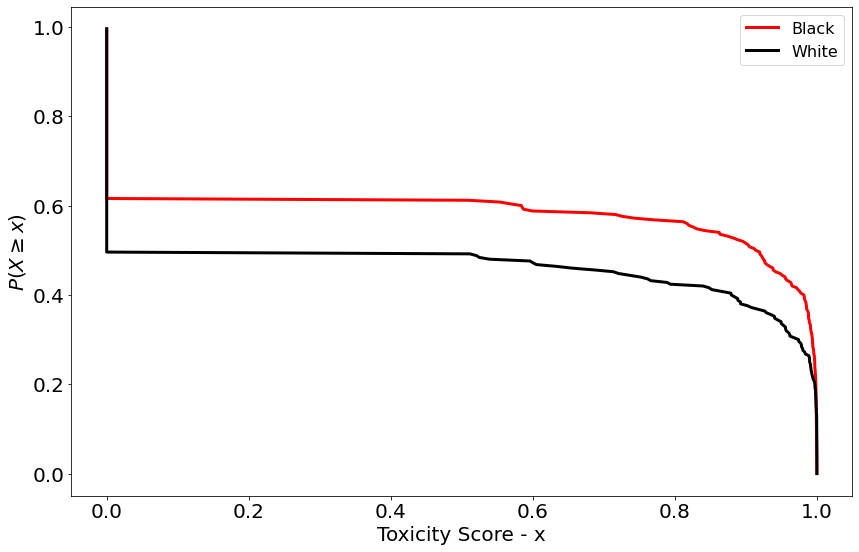

In [6]:
figure, ax = plt.subplots(figsize=(14,9))

group_color = {
    "Black": "red",
    "White": "black"
}
for group in group_color.keys():
    df_group = df_data_desc[df_data_desc.group == group]
    
    dfs = []
    count = 0
    for filename in df_group.filename.values:
        try:
            df = pd.read_csv(os.path.join(filepaths["04_twitter_scored"], filename))
            dfs.append(df)
        except:
            count += 1
    
    print(f"Group: `{group}` had {count} reading problems")
    
    df = pd.concat(dfs)
    del dfs
    
    ecdf = ECDF(df[score_name])
    ax.plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])

plt.xlabel("Toxicity Score - x")
plt.ylabel(r"$P(X \geq x)$")

plt.legend()
plt.savefig(os.path.join(filepaths["twitter_imgs"], f"{score_name}_icdf.pdf"))
plt.show()

---

### Toxicity Score Distribution

Group: `Black` had 0 reading problems
Group: `White` had 0 reading problems


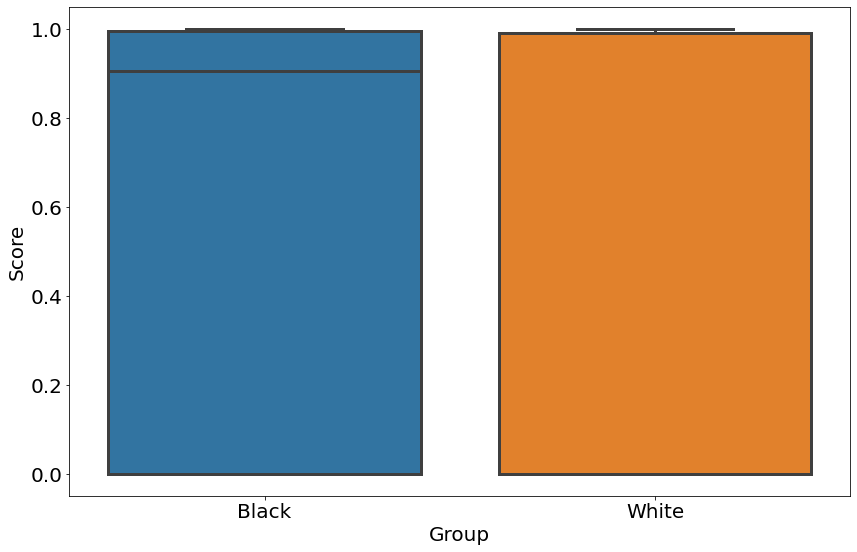

In [7]:
plt.subplots(figsize=(14,9))

dfs = []
for group in df_data_desc["group"].unique():
    df_group = []
    count = 0
    for filename in df_data_desc.loc[df_data_desc.group == group, "filename"].values:
        try:
            df = pd.read_csv(os.path.join(filepaths["04_twitter_scored"], filename))
            
            df = df[~df.has_swearing]
            df_group.append(df)
        except:
            count += 1
    
    print(f"Group: `{group}` had {count} reading problems")
    
    df_group = pd.concat(df_group)
    df_group["group"] = group
    
    dfs.append(df_group)

df = pd.concat(dfs)
del dfs, df_group

sns.boxplot(data=df, x="group", y=score_name, showfliers=False)
plt.xlabel("Group")
plt.ylabel("Score")

plt.show()

---

### Two-Sample Kolmogorov-Smirnov's Test

In [8]:
ks_all = []
groups = df.group.unique()
for first_group in groups:
    ks_one_vs_all = []
    for second_group in groups:
        statistic, p_value = ks_2samp(
            df[df.group == first_group][score_name],
            df[df.group == second_group][score_name]
        )
        
        ks_one_vs_all.append(
            f"{np.abs(np.round(statistic*100, 3))} ({np.round(p_value*100, 3)})"
        )
    ks_all.append(ks_one_vs_all)

In [9]:
pd.DataFrame(ks_all, columns=groups, index=groups)

,Black,White
Black,0.0 (100.0),14.713 (2.03)
White,14.713 (2.03),0.0 (100.0)
